# Article correlation

This file explores the correlation of articles in order to answer the following questions:

- Which articles are typically ordered together? (e.g. different sizes of same product)
- Which articles are typically NOT ordered together? (e.g. products that are substitutes for each other)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
# Import data
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'csv', 'clean.csv'))

We aggregate on month so that we can discover patterns even if the orders are not placed on exactly the same date. Also, this enables us to capture correlation in demand across regions.

In [3]:
# Aggregate on month
by_month = df.groupby(['ArticleVersionLast', 'DescriptionArticleEn',
                       'Date']).sum()
by_month = by_month.reset_index()

We remove outliers to prevent single extreme orders from blowing up correlation coefficients.

In [4]:
# Compute
averages = by_month.groupby([
    'ArticleVersionLast',
    'DescriptionArticleEn',
]).agg(MeanQty=('Ordered quantity', 'mean'), StdQty=('Ordered quantity', 'std'))

In [5]:
# Remove outliers (> 3 standard deviations from the mean)
by_month['MeanQty'] = by_month.apply(
    lambda row: averages.loc[row['ArticleVersionLast']]['MeanQty'][0], axis=1)
by_month['StdQty'] = by_month.apply(
    lambda row: averages.loc[row['ArticleVersionLast']]['MeanQty'][0], axis=1)
by_month['Outlier'] = by_month.apply(
    lambda row: True
    if row['Ordered quantity'] > row['MeanQty'] + 3 * row['StdQty'] else False,
    axis=1)
by_month = by_month[~by_month['Outlier']]

In [6]:
# Create correlation matrix
by_month = by_month[by_month['Ordered quantity'].notna()]
reindexed = by_month.reset_index().set_index('ArticleVersionLast')
pt = reindexed.pivot_table(values='Ordered quantity',
                           index=reindexed.index,
                           columns='Date',
                           aggfunc='first').fillna(0).T
corr = pt.corr()
dim = corr.shape[0]
# Subtract by identity matrix so as to exclude the product itself when we identify highly correlated articles
corr = corr - np.identity(dim)

In [7]:
# Get the most strongly correlated articles
CORR_THRESHOLD = 0.8

most_corr = corr.apply(
    lambda row: row[row.abs() > CORR_THRESHOLD].index.tolist(), axis=1)
most_corr = most_corr[most_corr.apply(lambda row: len(row) > 0)]

# All articles are mapped to a list of articles with absolute correlation > CORR_TRESHOLD
most_corr.head()

ArticleVersionLast
ADAPLAPALT4P-    [ADAPLAPSLT4B-]
ADAPLAPSLT4B-    [ADAPLAPALT4P-]
CWATDISINTF-      [SCTDSYEN05--]
CWATINSERA5P-     [SDIMFILMG24-]
CWATINSERM3S-     [KCOMZBE0067-]
dtype: object

In [8]:
# Map articles to their descriptions
articles = df.groupby(['ArticleVersionLast',
                       'DescriptionArticleEn']).sum().reset_index()[[
                           'ArticleVersionLast', 'DescriptionArticleEn'
                       ]]

article_map = dict(
    zip(articles['ArticleVersionLast'], articles['DescriptionArticleEn']))

In [9]:
# Flatten correlated articles into a table
flat_articles = []
for article, corr_articles in most_corr.items():
  for ca in corr_articles:
    flat_articles.append((article, ca))

most_corr = pd.DataFrame(flat_articles).rename(
    columns={
        0: 'ArticleVersionLast',
        1: 'CorrelatedArticleVersionLast'
    })

In [10]:
# Add correlation coefficients and article descriptions
most_corr['corr'] = most_corr.apply(lambda row: corr[row['ArticleVersionLast']]
                                    [row['CorrelatedArticleVersionLast']],
                                    axis=1)
most_corr['ArticleDescription'] = most_corr.apply(
    lambda row: article_map[row['ArticleVersionLast']], axis=1)
most_corr['CorrelatedArticleDescription'] = most_corr.apply(
    lambda row: article_map[row['CorrelatedArticleVersionLast']], axis=1)

In [18]:
# Remove duplicate rows and inspect the most strongly correlated articles
most_corr = most_corr.groupby([
    'ArticleVersionLast', 'CorrelatedArticleVersionLast', 'ArticleDescription',
    'CorrelatedArticleDescription'
]).sum().sort_values(by='corr', ascending=False).drop_duplicates()
most_corr.head(10)

corr
ArticleVersionLast CorrelatedArticleVersionLast ArticleDescription                                 CorrelatedArticleDescription                                
YHON40530-KRH-781- YHON41201-KRH-780-           DRIVE CHAIN, XL125LK                               SPROCKET, rear, XL125LK                             0.983437
SPPEGLENES-T02     SPPEGLENEL-T02               GLOVE, EXAMINATION, nitrile, extended cuff, s.u... GLOVE, EXAMINATION, nitrile.,extended cuff, s.u...  0.982291
ELAECCHT201-       ELAECCHT202-                 (clinical chem. Reflotron) CREATININE, strip 10... (clinical chem. Reflotron) GPT (ALT), strip 107...  0.968846
TMOTPROTEO--       TMOTPROTKO--                 ELBOW PROTECTORS, one size, for motorbike, pair    KNEE PROTECTORS, one size, for motorbike, pair      0.952031
ESTEAUTS918-       ESTEAUTS917-                 (autoclave TBM 90 l) DISCHARGE VALVE, 134°C T00003 (autoclave TBM 90 l) DISCHARGE VALVE, 121°C, T0...  0.945721
ELAECCHT203-       ELAECCHT201-                 (clinical chem. Reflotron) K+ POTASSIUM, strip ... (clinical chem. Reflotron) CREATININE, strip 10...  0.944622
DINJIMCI55V-       PSAFMASKRF2T01               IMIPENEM 500mg/ CILASTATIN sodium 500mg, powder... RESPIRATOR FFP2 or N95, disposable                  0.933766
YTOY90368-45087-   YTOY90368-49084-             BEARING OUTER wheel hub, FR&RR, HZJ7#              BEARING INNER wheel hub, FR&RR, HZJ7#               0.929429
SPPEHOOD2--T01     DORACHLQ3T-T01               HOOD, non-woven, integrated mask, VHF, s.u         CHLOROQUINE, 155mg base, (250mg phosphate), tab.    0.912033
SDDCCONT30AL-      DORACHLQ3T-T01               CONTAINER for drugs, plastic, amber, 30 ml + lid   CHLOROQUINE, 155mg base, (250mg phosphate), tab.    0.908639

In [19]:
# Correlation plotting
ARTICLE_IDS = ['YHON40530-KRH-781-', 'YHON41201-KRH-780-']
b = by_month[by_month['ArticleVersionLast'].isin(ARTICLE_IDS)]
b = b.groupby(['ArticleVersionLast', 'Date']).sum()
b = b.reset_index()
title_1 = 'Quantity of ' + ARTICLE_IDS[0]
title_2 = 'Quantity of ' + ARTICLE_IDS[1]
b[title_1] = b.apply(lambda row: row['Ordered quantity']
                     if row['ArticleVersionLast'] == ARTICLE_IDS[0] else None,
                     axis=1)
b[title_2] = b.apply(lambda row: row['Ordered quantity']
                     if row['ArticleVersionLast'] == ARTICLE_IDS[1] else None,
                     axis=1)

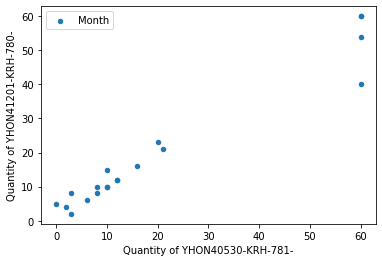

In [26]:
# Scatter plot
fig, ax = plt.subplots()
b.groupby('Date').sum().plot.scatter(x=title_1, y=title_2, ax=ax)
ax.legend(['Month'])

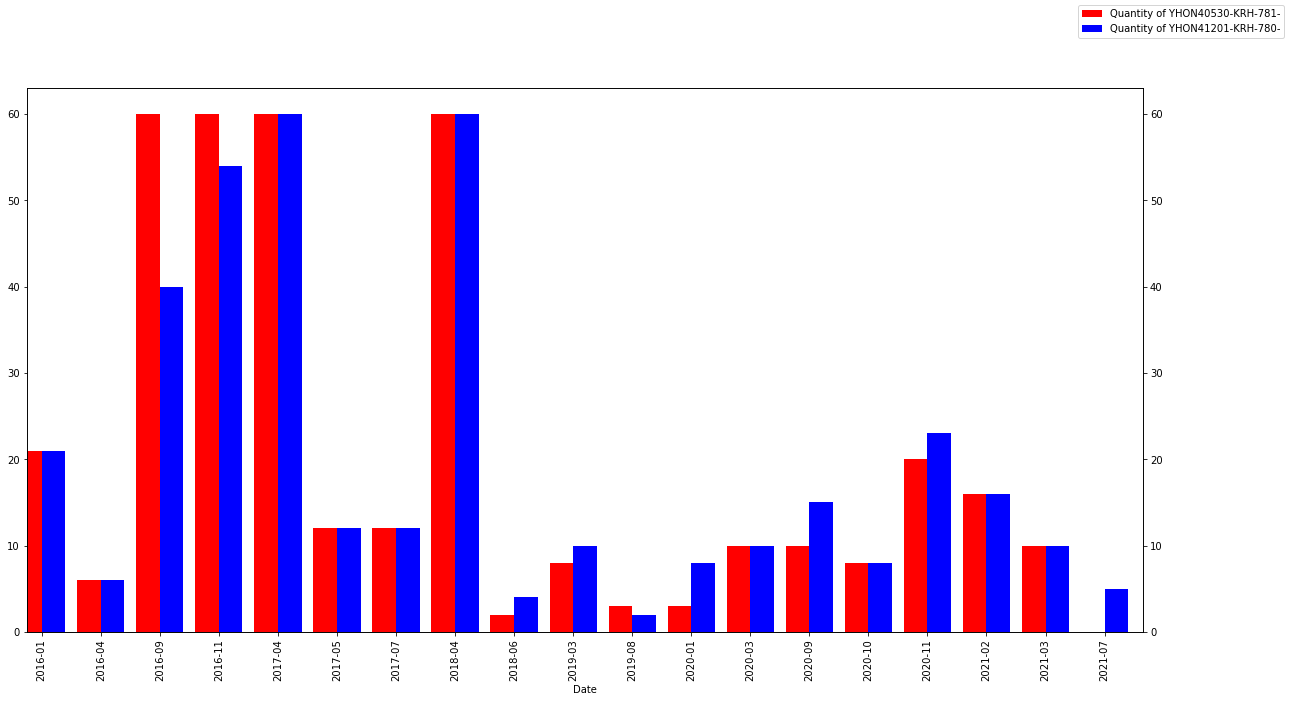

In [38]:
# Double bar plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
b.groupby('Date').sum()[title_1].plot(kind='bar',
                                      figsize=(20, 10),
                                      color='red',
                                      ax=ax,
                                      width=0.4,
                                      position=1)
b.groupby('Date').sum()[title_2].plot(kind='bar',
                                      figsize=(20, 10),
                                      color='blue',
                                      ax=ax2,
                                      width=0.4,
                                      position=0)
fig.legend(['Quantity of ' + ARTICLE_IDS[0], 'Quantity of ' + ARTICLE_IDS[1]])
plt.show()